L'objectif de ce notebook est d'étudier la régression linéaire en dimension 1 avec le formalisme et la théorie étudiée dans l'article "On the Validation of Gibbs Algorithms: Training Datasets, Test Datasets and their Aggregation". 

La cellule suivante crée deux datasets d'écart type différents mais correspondant à la même droite de coefficient directeur 1 et d'ordonnée à l'origine 1.

In [5]:


import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
import seaborn as sns



#paramètres 

N = 100 #taille du dataset
Lambda = 1
q = lambda x,y : 1 #la densité par rapport à la mesure de Lebesgue de Q

#commençons par créer les dataset à étudier

z1 = []

for i in range(N):
    x = np.random.normal(0,1)
    epsilon = np.random.normal(0,0.1)
    y = x + epsilon + 1
    z1.append((x,y))


z2 = []

for i in range(N):
    x = np.random.normal(0,1)
    epsilon = np.random.normal(0,5)
    y = x + epsilon +1
    z2.append((x,y))

z0 = z1 + z2



On définit les fonctions nécessaires pour calculer le risque empirique.

In [6]:
#on définit la loss function

def loss(y1,y2): 
    return (y1-y2)**2

#on définit notre approximation pour les paramètres (a,b)

def approximation(a,b,t):
    return a*t+b

#on définit la fonction de risque empirique

def empirical_risk(a,b,z):
    res = 0
    for i in range(len(z)):
        xi = z[i][0]
        yi = z[i][1]
        res += loss(approximation(a,b,xi),yi)
    res = res/N
    return res





La méthode traditionnelle utilisée en ML pour trouver les paramètres de la régression linéaire consiste à chercher les paramètres qui minimisent le risque empirique (problème ERM), nous implémentons donc une descente de gradient pour résoudre ce problème.

In [8]:
"""Résolution du problème ERM par descente de gradient"""

def gradient(a,b,z):
    Sa = 0
    for i in range(len(z)):
        xi = z[i][0]
        yi = z[i][1]
        Sa += xi * (a * xi + b - yi)
    Sa = Sa * (2/len(z))
    return Sa

def solve_ERM(a0,b0,epsilon,z,pas):
    a1 = a0 - pas * gradient(a0,b0,z)
    b1 = b0 - pas * gradient(a0,b0,z)
    while (a1-a0)**2 +(b1-b0)**2 > epsilon**2:
        a0 = a1
        a1 = a0 - pas * gradient(a0,b0,z)
        b0 = b1
        b1 = b0 - pas * gradient(a0,b0,z)
    return a1,b1




L'article étudie une autre méthode, plutôt que de déterminer un vecteur de paramètre, on cherche la loi de probabilité de ce vecteur. Cette loi de probabilité est la solution du problème ERM-RER étudié dans l'article. 

In [9]:
"""Résolution du problème ERM-RER"""

#calcul de l'espérance du risque empirique

def expected_empirical_risk(f,z):
    def g(a,b):
        return f(a,b)*empirical_risk(a,b,z)
    return si.dblquad(g,-np.inf,np.inf,-np.inf,np.inf)




#résolvons le problème ERM-RER, le programme suivant renvoit la densité de la solution

def solve_ERM_RER(z,Lambda):
    def g(a,b):
        return np.exp(-empirical_risk(a,b,z)/Lambda)
    normalisation = si.dblquad(g,-np.inf,np.inf,-np.inf,np.inf)[0]
    def sol(a,b):
        return (np.exp(-empirical_risk(a,b,z)/Lambda))/normalisation
    return sol


f = solve_ERM_RER(z1,Lambda)
si.dblquad(f,-np.inf,np.inf,-np.inf,np.inf)


(0.9999999999999902, 1.4761283337659047e-08)

Nous allons visualiser la loi de probabilité en question, pour cela nous affichons la heatmap de la solution ERM-RER pour plusieurs valeurs de Lambda. On observe une concentration de la mesure autour de la solution ERM lorsque Lambda tend vers 0.

(1.000000000074253, 1.4827000891524787e-08)


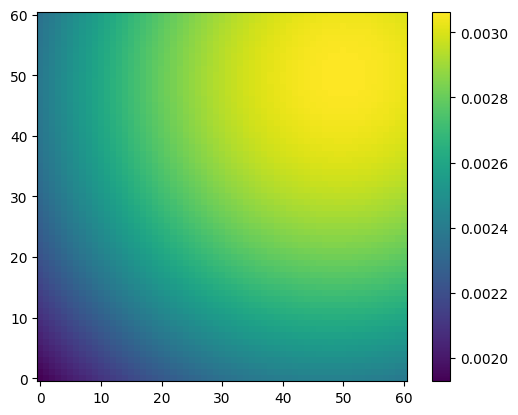

(1.0000000000140021, 1.2977946763346477e-08)


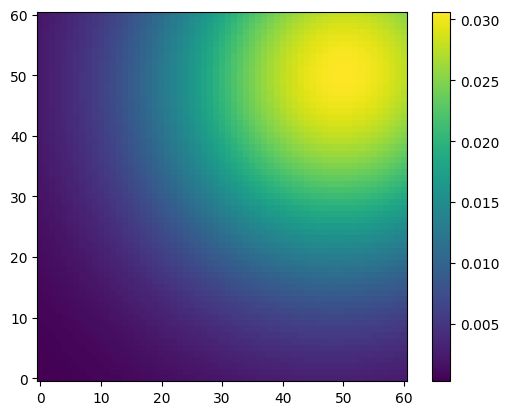

(0.9999999999999902, 1.4761283337659047e-08)


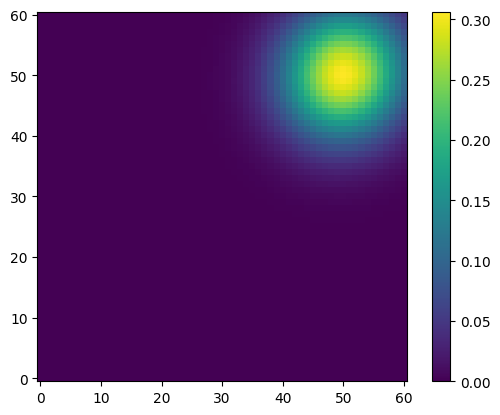

(0.9999999999998477, 1.4291183017116426e-08)


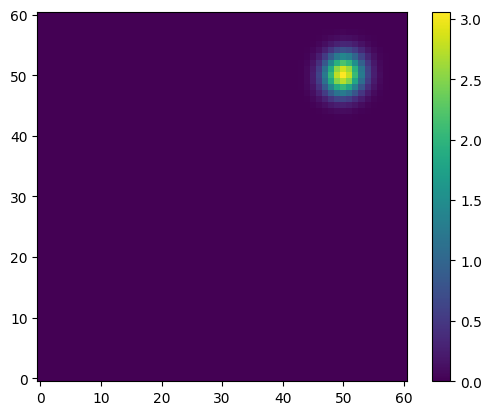

In [12]:
"""Visualisation des solutions au problème ERM-RER"""

import matplotlib.pyplot as plt

def visualisation_ERM_RER(Lambda,z,n,pas):
    f = solve_ERM_RER(z,Lambda)
    print(si.dblquad(f,-np.inf,np.inf,-np.inf,np.inf))
    M = np.zeros((2 * n * pas + 1 ,2 * n * pas + 1))
    for i in range(2 * n * pas + 1):
        for j in range(2 * n * pas + 1):
            M[i][j] = f(i / pas - n - 1,j / pas - n - 1)
    plt.imshow(M,origin="lower")
    plt.colorbar()
    plt.show()



for param in [100,10,1,0.1]:
    visualisation_ERM_RER(param,z1,3,10)


La cellule suivante étudie la question de l'agrégat de datasets. Est-ce qu'il vaut mieux résoudre ERM-RER sur deux datasets séparemment et calculer la mesure moyenne des deux solutions ou alors résoudre ERM-RER sur le dataset fusionné ?

In [ ]:
#on calcul des GA des 3 datasets
import time

#calcul chronométré de f1

start = time.time()

f1 = solve_ERM_RER(z1,Lambda)

end = time.time()
elapsed = end - start

print(f'Temps d\'exécution calcul de f1 : {elapsed:.2}ms')

#calcul chronométré de f2

start = time.time()

f2 = solve_ERM_RER(z2,Lambda)

end = time.time()
elapsed = end - start

print(f'Temps d\'exécution calcul de f2 : {elapsed:.2}ms')

#calcul chronométré de f0

start = time.time()

f0 = solve_ERM_RER(z0,Lambda)

end = time.time()
elapsed = end - start

print(f'Temps d\'exécution calcul de f0 : {elapsed:.2}ms')

def sum(f1,f2):
    def g(a,b):
        return f1(a,b)+f2(a,b)
    return g

def scalar(f,alpha):
    def g(a,b):
        return alpha*f(a,b)
    return g

f3 = scalar(sum(f1,f2),0.5)
    

#calcul des EER sur leur dataset

R1 = expected_empirical_risk(f1,z1)
R2 = expected_empirical_risk(f2,z2)
R0 = expected_empirical_risk(f0,z0)

print("R0 : " + str(R0) +" R1 : " + str(R1) +" R2 : " +str(R2))

F = [f0,f1,f2,f3]
z = [z0,z1,z2]
res = np.zeros((4,3))
for i in range(len(F)):
    for j in range(len(z)):
        res[i][j] = expected_empirical_risk(F[i],z[j])[0]
print(res)

Ici nous allons évaluer la densité de la solution ERM-RER en la solution ERM pour Lambda entre 0.01 et 0.5. On observe une divergence vers +infini quand lambda tend vers 0, cela n'est pas surprenant car quand Lambda tend vers 0, le problème s'apparente au problème ERM donc la mesure solution de ERM-RER est un dirac en la solution ERM.

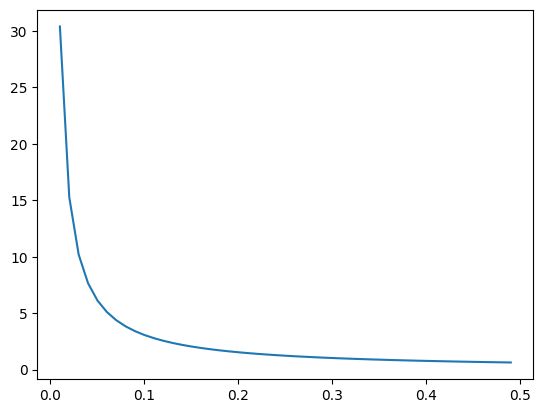

In [13]:



def visualisation_concentration_measure(z,L):    #L est la liste des lambda étudiés
    res = []
    a0, b0 = solve_ERM(1,1,10**-9,z,0.001)
    for Lambda in L:
        f0 = solve_ERM_RER(z,Lambda)
        res.append(f0(a0,b0))
    plt.plot(L,res)
    plt.show

L1 = [i/100 for i in range(1,50)]

visualisation_concentration_measure(z1,L1)

